<a href="https://colab.research.google.com/github/ManamperiOV/Resume-Screening-Assistant/blob/main/job_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
pip install --upgrade datasets transformers numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Resume Screening Assistant (NLP)/UpdatedResumeDataSet.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
df.shape

(962, 2)

    Number of Job Categories (Unique)

In [ ]:
print(df['Category'].nunique())

25


    Number of Resumes per Job Category

In [ ]:
per_category = df['Category'].value_counts()

print(per_category)

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64


/tmp/ipython-input-8-4249871313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=per_category.index, y=per_category.values, palette="viridis")


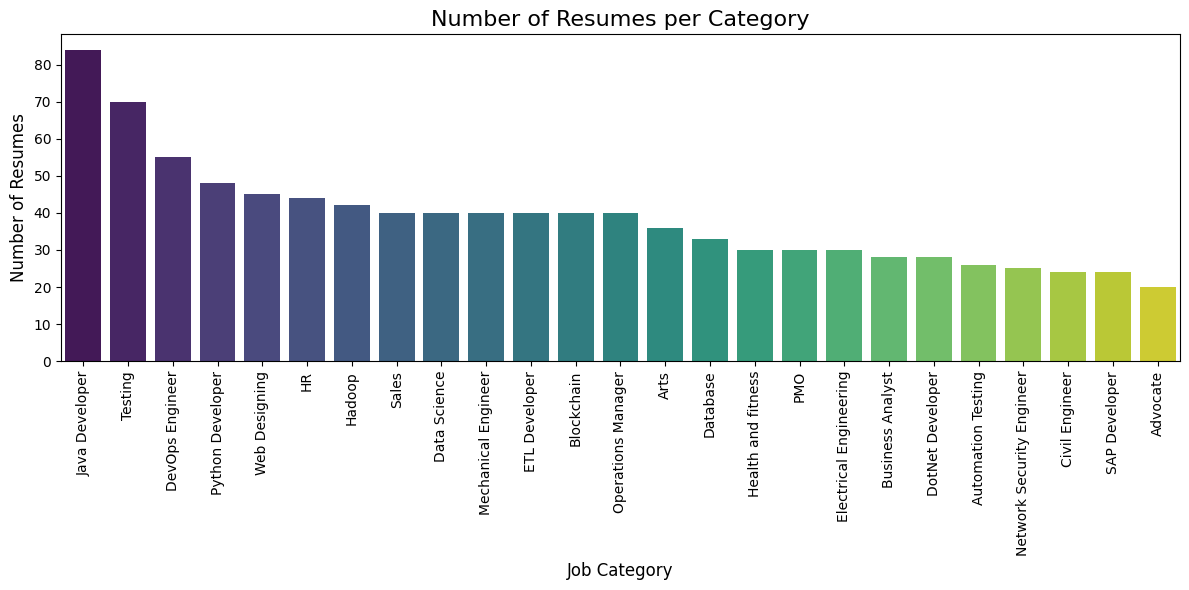

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=per_category.index, y=per_category.values, palette="viridis")
plt.title("Number of Resumes per Category", fontsize=16)
plt.xlabel("Job Category", fontsize=12)
plt.ylabel("Number of Resumes", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

    Check for Missing Data

In [ ]:
df.isnull().sum()

,0
Category,0
Resume,0


    Try oversampling to fix imbalance of data

In [ ]:
# First find max number of resumes in any category
max_size = df['Category'].value_counts().max()
print(max_size)

84


In [ ]:
# Oversample samll categories to match max category
df2 = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)

/tmp/ipython-input-11-2432132534.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)


In [ ]:
# Shuffle data frame randomly (row-wise)
df = df2.sample(frac=1).reset_index(drop=True)

In [ ]:
# New distribution of resumes per Category
print(df['Category'].value_counts())

Category
Civil Engineer               84
Sales                        84
Arts                         84
Python Developer             84
Web Designing                84
Electrical Engineering       84
DevOps Engineer              84
Blockchain                   84
PMO                          84
Data Science                 84
Operations Manager           84
Testing                      84
Advocate                     84
HR                           84
ETL Developer                84
Automation Testing           84
Database                     84
Mechanical Engineer          84
SAP Developer                84
Health and fitness           84
Network Security Engineer    84
Hadoop                       84
DotNet Developer             84
Java Developer               84
Business Analyst             84
Name: count, dtype: int64


    Check Samples of Resume Column to see what we are dealing with

In [ ]:
for i in range(5):
    print(f"\nResume {i+1}")
    print("Category:", df['Category'][i])
    print("Text Preview:", df['Resume'][i][:300])


Resume 1
Category: Civil Engineer
Text Preview: COMPUTER KNOWLEDGE â¢ Drafting tools: AutoCAD. â¢ Packages: MS Office Applications â¢ Operating systems: Windows 9x/2000/XP/Vista. DETAILEXPERIENCES Experience in India: 1) Working Experience at ALIA CONSTRUCTION AT NALLASOPARA (WEST) Mumbai since JUNE 2014 to MAY 2015. As a Civil Engineer (1 yea

Resume 2
Category: Sales
Text Preview: KEY SKILLS: â¢ Planning & Strategizing â¢ Presentation skill â¢ Client relationship â¢ Energy level â¢ Enquiry Generation â¢ Achieving Targets QUALIFICATIONS: A university in marketing or business studies is preferred or a minimum of three years of related experience in sales & marketing secto

Resume 3
Category: Arts
Text Preview: â¢ Good communication skill â¢ Quick learner â¢ Keen to find solutionsEducation Details 
 MBA Marketing and International Business Management Pune, Maharashtra Pune University
 B-Tech Tech Nagpur, Maharashtra RTM Nagpur University
G.M. Arts, Commerce & Science 

G.M.

    Random text and other Jibberish, Must clean text with Regex

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Define stop-words "the," "and," "is," "in," "for," and "it" in ENGLISH
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove Twitter RT (retweet) or cc if any
    text = re.sub(r'\b(rt|cc)\b', ' ', text)

    # Remove emails and usernames
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove non-ASCII characters (like emojis)
    text = re.sub(r'[^\x00-\x7f]', ' ', text)

    # Remove digits and special characters (except basic punctuation)
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', text)

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing spaces
    text = text.strip()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Join back into a single string
    return " ".join(filtered)

# Apply the cleaning function
df['Resume'] = df['Resume'].apply(clean_text)

In [ ]:
for i in range(5):
    print(f"\nResume {i+1}")
    print("Category:", df['Category'][i])
    print("Text Preview:", df['Resume'][i][:300])


Resume 1
Category: Civil Engineer
Text Preview: computer knowledge drafting tools autocad packages office applications operating systems windows 2000 vista detailexperiences experience india working experience alia construction nallasopara west mumbai since june 2014 may 2015 civil engineer years project handle project title yashwant orichids pos

Resume 2
Category: Sales
Text Preview: key skills planning strategizing presentation skill client relationship energy level enquiry generation achieving targets qualifications university marketing business studies preferred minimum three years related experience sales marketing sector problem solving analytical skills interpret sales per

Resume 3
Category: Arts
Text Preview: good communication skill quick learner keen find solutionseducation details mba marketing international business management pune maharashtra pune university tech tech nagpur maharashtra rtm nagpur university arts commerce science arts commerce science skill details comp

    Encode Labels

In [ ]:
# Encode job categories as integers
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Category'])

# Save mapping for future decoding
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'Advocate': np.int64(0), 'Arts': np.int64(1), 'Automation Testing': np.int64(2), 'Blockchain': np.int64(3), 'Business Analyst': np.int64(4), 'Civil Engineer': np.int64(5), 'Data Science': np.int64(6), 'Database': np.int64(7), 'DevOps Engineer': np.int64(8), 'DotNet Developer': np.int64(9), 'ETL Developer': np.int64(10), 'Electrical Engineering': np.int64(11), 'HR': np.int64(12), 'Hadoop': np.int64(13), 'Health and fitness': np.int64(14), 'Java Developer': np.int64(15), 'Mechanical Engineer': np.int64(16), 'Network Security Engineer': np.int64(17), 'Operations Manager': np.int64(18), 'PMO': np.int64(19), 'Python Developer': np.int64(20), 'SAP Developer': np.int64(21), 'Sales': np.int64(22), 'Testing': np.int64(23), 'Web Designing': np.int64(24)}


    Split Train/Test

In [ ]:
X = df['Resume'].values
y = df['Encoded_Label'].values

# Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 1680
Testing samples: 420


    Save Preprocessed data

In [ ]:
# Create a DataFrame to save cleaned and split data
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

    Convert pandas DataFrame to Hugging Face dataset format

In [ ]:
from datasets import Dataset

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

    Tokenize with DistilBERT

In [ ]:
from transformers import AutoTokenizer

# Use DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Apply tokenizer
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

### Tokenizer
- The tokenizer converts raw text into token IDs that the model can understand. Transformers models require tokenized inputs (numerical IDs) rather than raw text.
- "distilbert-base-uncased" means the tokenizer lowercases the text and uses the base DistilBERT vocabulary.

### The function tokenize_function()
- It tokenizes the text in the "text" field.
- padding="max_length": Pads all sequences to the maximum length (512 tokens here).
- truncation=True: Truncates sequences longer than max_length to 512 tokens.
- max_length=512: Sets the max sequence length to 512 tokens.
- Returns a dictionary with tokenized outputs like input_ids, attention_mask, etc.

### Applying Tokenizer to the Dataset
- .map() applies the tokenize_function to every example in the dataset.
- batched=True means the function receives a batch of examples (list of texts) instead of one example at a time — this speeds up processing.
- The datasets now include tokenized inputs (input_ids, attention_mask, etc.) alongside the original data.

### Set Dataset format for Pytorch
- set_format(type="torch") converts the dataset columns into PyTorch tensors. This makes the dataset compatible with PyTorch models and DataLoaders.
- Only the columns input_ids, attention_mask, and label are included in the output tensors. This simplifies feeding data directly into a PyTorch model during training or evaluation.

    Load pretrained model for classification

In [ ]:
from transformers import AutoModelForSequenceClassification

# Number of unique categories
num_labels = len(train_df['label'].unique())

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

### num_labels
- unique(): Finds all unique label values.
- len(...): Counts how many unique labels there are
- This gives  the total number of classes your model needs to predict, which is stored in num_labels.
### Load Model
- AutoModelForSequenceClassification is a class from Hugging Face Transformers that loads a pre-trained transformer model tailored for sequence classification tasks
- from_pretrained("distilbert-base-uncased") loads the DistilBERT base model with uncased vocabulary, pre-trained on a large corpus.
- The argument num_labels=num_labels tells the model how many output classes it should have.
### Warning
- DistilBERT model is pre-trained on general language modeling, but the classification head is task-specific and must be trained from scratch.
- The warning advises you to fine-tune/train the model on your labeled dataset before using it for predictions or inference to get meaningful results.

    Training Setup

In [ ]:
from transformers import TrainingArguments, Trainer, EvalPrediction
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# Define compute metrics
def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

### Defining Training Arguments
- output_dir: Directory where model checkpoints and outputs will be saved.
- eval_strategy="epoch": Evaluate the model at the end of every epoch.
- logging_strategy="epoch": Log training metrics at the end of every epoch.
- save_strategy="epoch": Save model checkpoints at the end of every epoch.
- num_train_epochs=3: Train the model for 3 full passes over the training data.
- per_device_train_batch_size=8: Batch size per GPU/CPU device during training.
- per_device_eval_batch_size=8: Batch size per device during evaluation.
- warmup_steps=100: Number of steps for learning rate warmup to stabilize training.
- weight_decay=0.01: L2 regularization to prevent overfitting.
- logging_dir: Directory where logs (for TensorBoard etc.) will be stored.
- load_best_model_at_end=True: After training, automatically load the checkpoint with the best evaluation metric.
- metric_for_best_model="accuracy": Use accuracy metric to determine the best model checkpoint.
### Defining the Metrics Computation Function
- The function takes an EvalPrediction object containing raw model predictions and true labels.
- p.predictions.argmax(-1): Converts model output logics to predicted class indices by taking the index of the max logic.
- Calculates:
    - Accuracy: Proportion of correctly predicted labels.
    - Weighted F1 score: Harmonic mean of precision and recall, weighted by class support (useful for imbalanced classes).
- Returns a dictionary of metric names and values, which the Trainer will log and use.
### Creating the Trainer Object
- model: The pre-trained transformer model (e.g., DistilBERT) with a classification head.
- args: The training arguments defined above.
- train_dataset: Dataset used for training.
- eval_dataset: Dataset used for evaluation after each epoch.
- compute_metrics: Function to compute evaluation metrics during and after training.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.139800,0.384464,0.978571,0.978352
2,0.099600,0.018958,0.997619,0.997615
3,0.016500,0.012691,0.997619,0.997615


TrainOutput(global_step=630, training_loss=0.751981438530816, metrics={'train_runtime': 269.6756, 'train_samples_per_second': 18.689, 'train_steps_per_second': 2.336, 'total_flos': 667909534924800.0, 'train_loss': 0.751981438530816, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.018958382308483124,
 'eval_accuracy': 0.9976190476190476,
 'eval_f1': 0.9976146587667325,
 'eval_runtime': 6.0174,
 'eval_samples_per_second': 69.797,
 'eval_steps_per_second': 8.808,
 'epoch': 3.0}

In [ ]:
trainer.save_model("/content/drive/MyDrive/Resume Screening Assistant (NLP)/resume_classifier")
tokenizer.save_pretrained("/content/drive/MyDrive/Resume Screening Assistant (NLP)/resume_classifier")

  Test Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load your saved model and tokenizer
model_path = "/content/drive/MyDrive/Resume Screening Assistant (NLP)/resume_classifier"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set model to inference mode

In [ ]:
import joblib

label_map = {
    0: "Advocate",
    1: "Arts",
    2: "Automation Testing",
    3: "Blockchain",
    4: "Business Analyst",
    5: "Civil Engineer",
    6: "Data Science",
    7: "Database",
    8: "DevOps Engineer",
    9: "DotNet Developer",
    10: "ETL Developer",
    11: "Electrical Engineering",
    12: "HR",
    13: "Hadoop",
    14: "Health and Fitness",
    15: "Java Developer",
    16: "Mechanical Engineer",
    17: "Network Security Engineer",
    18: "Operations Manager",
    19: "PMO",
    20: "Python Developer",
    21: "SAP Developer",
    22: "Sales",
    23: "Testing",
    24: "Web Designing"
}

In [ ]:
def predict_resume_category(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Disable gradient calculation (inference only)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax(dim=-1).item()

    # Map predicted label to category name
    return label_map.get(predicted_class_id, "Unknown")

In [ ]:
sample_resume = """
Experienced data analyst with strong Python, SQL, and machine learning skills.
Built predictive models and dashboards using Pandas, Scikit-learn, and Tableau.
"""

prediction = predict_resume_category(sample_resume)
print("Predicted Category:", prediction)

Predicted Category: Data Science
